&nbsp;

# 10 - Analyse multivariée

---

&nbsp;

Dans notre projet, on ne regarde pas une seule variable en fonction du temps mais bien un champs spatial de SST qui évolue dans le temps, des milliers de points spatiaux corrélés entre eux. L'analyse multivariée traite l'ensemble de ces points simultanément.

Représenté mathématiquement, cela correspond à chaque instant $ t $ :

$$ X(t) \in \mathbb{R}^{N_{points}} $$

Puis sur toute la période :

$$ \mathbb{X} \in \mathbb{R}^{N_{t}\times N_{space}} $$

L'objectif de l'analyse qui va suivre est de déterminer une structure commune dans cette matrice. Mais $N_{points}$ représente dans notre cas 8400 points spatiaux (~3500 sans compter les points terrestres), tous avec une forte corrélation spatiale donc. La dimensionnalité va donc être "redondante".

La réduction de dimensionnalité s'impose donc. Sans cela, on s'expose à un apprentissage instable, une sur-paramétrisation massive et une interprétation impossible. Le modèle ne doit apprendre ni le bruit, ni la grille, mais la dynamique.

&nbsp;

> #### La dynamique des anomalies de SST est-elle gouvernée par quelques structures spatiales dominantes ou par un grand nombre de degrés de liberté ?

Réduire la dimensionnalité c'est testé l'hypothèse d'une gouvernance de quelques modes dominants au sein du jeu de donnée. Il est légitime physiquement de soutenir et vérifier une telle hypothèse car les champs océaniques sont continus, lissés par la diffusion et gouvernés par des processus de grandes échelles. La variété de dimension est faible mais les espaces sont grands.

Le point de départ idéal pour répondre à cette question serait d'appliquer la EOF (Empirical Orthogonal Function).

&nbsp;

> #### Pourquoi appliquer la EOF ?

On va à tout prix chercher à réduire la dimensionnalité avant tout apprentissage machine SciML via un modèle comme Neural ODE. Il nous faut construire un état réduit pour fournir une entrée compacte pour éviter toute difficulté inutile.

En temps normal, on se dirigerait vers la PCA mais nous travaillons avec des champs géophysiques. EOF est la méthode préférable dans cette situation car elle cherche des modes orthogonaux, maximisant la variance et définis sur l'espace. Mathématiquement, on la représente de la manière suivante :

$$ X(x, y, t) \approx \overset{K}{\underset{k=1}{\sum}}a_k(t)\phi_k(x,y) $$

On sépare naturellement l'espace via $\phi(x,y)$ et le temps via $a(t)$. Contrairement à une réduction arbitraire, EOF utilise la covariance spatiale et regroupe les points corrélés pour extraire finalement des structures cohérentes.

On notera également que c'est un standard en climatologie en plus d'être linéaire, robuste et interprétable, ce qui encourage notre choix.




-6.695454413119251e-09


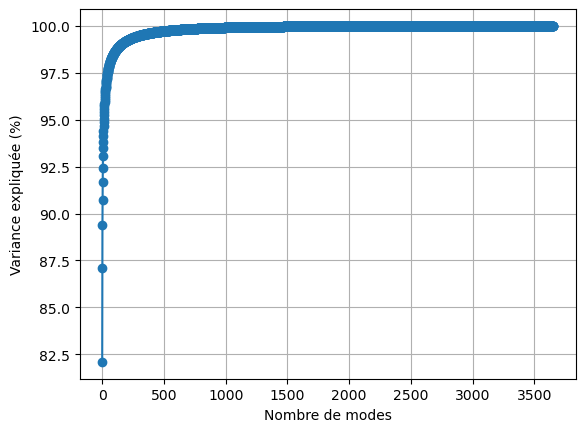

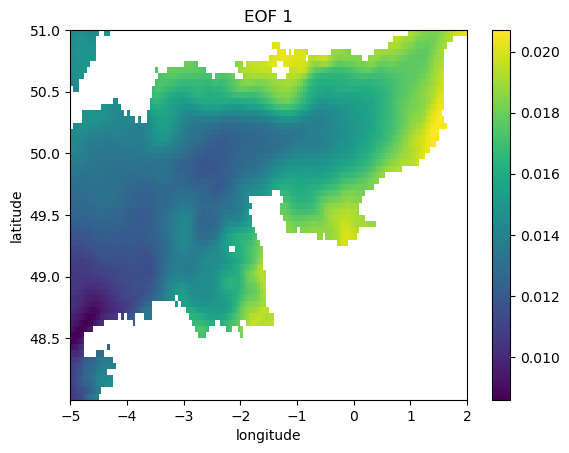

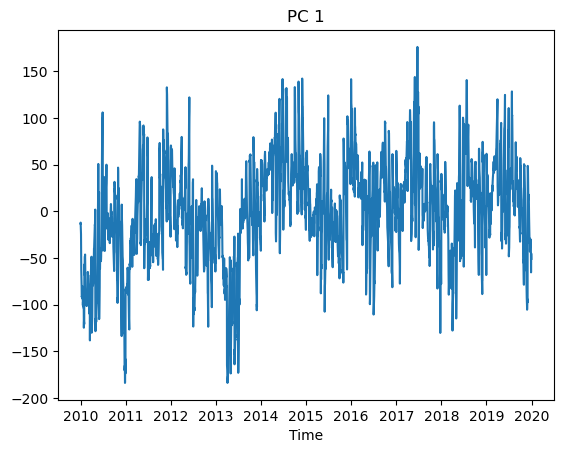

In [1]:
import xarray as xr
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

ds = xr.open_dataset("data/processed/sstDeseasonalizedCOPERNICUS20102019.nc")

sst = ds["analysed_sst"]
sstStacked = sst.stack(space=("latitude", "longitude"))

sstStacked = sstStacked.dropna("space")

print(float(sstStacked.mean()))

X = sstStacked.values  # shape (Nt, Nspace)

pca = PCA(svd_solver="full")
PCs = pca.fit_transform(X)

explainedVar = pca.explained_variance_ratio_

EOFs = xr.DataArray(
    pca.components_,
    dims=("mode", "space"),
    coords={"mode": np.arange(pca.n_components_),
            "space": sstStacked.space}
)

EOFs = EOFs.unstack("space")

PCs = xr.DataArray(
    PCs,
    dims=("time", "mode"),
    coords={"time": sst.time,
            "mode": np.arange(pca.n_components_)}
)

plt.figure()
plt.plot(np.cumsum(explainedVar)*100, marker="o")
plt.xlabel("Nombre de modes")
plt.ylabel("Variance expliquée (%)")
plt.grid()
plt.show()

EOFs.isel(mode=0).plot()
plt.title("EOF 1")
plt.show()

PCs.isel(mode=0).plot()
plt.title("PC 1")
plt.show()
